In [39]:
import sys
sys.path.append('../')
import numpy

from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu,\
    NewRewardUtils as nr \

from reward import AWSReward, RewardFactory
import reward.awsreward as rewards
from utils.loader import load_logs, load_sample_complete_laps
from utils.transformer import df_to_params, calculate_iteration, new_names_df

tu = TrackIO(base_path='../tracks')
track = tu.load_track("reinvent_base")
fname = '../logs/training-simulation-logs-w7.log'

full_df = load_logs(fname)
calculate_iteration(full_df)

full_df['duration'] = full_df[['episode','numeric_timestamp']].groupby('episode').transform(lambda x: x - x.min())

In [93]:
# rewards.RewardW6??

In [130]:
class new_reward(rewards.RewardW7):
    
    def base_reward(self):
        return -1
    

In [169]:
factory = RewardFactory(rewards.AWSReward)
factory.rewards()

['RewardZ2',
 'RewardZ3',
 'RewardZ1',
 'RewardZ4',
 'RewardZ4_2',
 'RewardZ5',
 'RewardZ6',
 'RewardZ7',
 'RewardY1',
 'RewardY2',
 'RewardX1',
 'RewardW8',
 'NewReward',
 'new_reward',
 'RewardW7',
 'RewardW6',
 'RewardW5',
 'RewardW4',
 'RewardW3',
 'RewardW2']

In [187]:
def df_by_episode(full_df, episode_number, factory, df_to_params, reward_name='new_reward'):
    df = full_df.loc[full_df['episode']==episode_number,:].copy()
    factory.calculate_new_reward(df, track.center_line, df_to_params, reward_name, missing_params=None)
    return calculate_cumulative_reward( df,['reward',reward_name])    

def calculate_cumulative_reward(df, reward_column_names, use_stream=False):
    groupby_cols = ['iteration','episode'] + ( ['stream'] if use_stream else [] )
    cumulative_reward = df.sort_values('step').loc[:,groupby_cols + reward_column_names ].groupby(groupby_cols).cumsum()
    cumulative_reward.columns = [f'cumulative_{x}' for x in cumulative_reward.columns]
    return df.merge( cumulative_reward, left_index=True,right_index=True )

def plot_new_reward(df,reward_names):
    import seaborn

    new_df = df.loc[:,['duration','step'] + [f'cumulative_{n}' for n in reward_names] ]
    new_df = new_df.set_index('duration').sort_index()
    seaborn.lineplot(data=new_df,)
    
def summary(df,reward_names):
    aggregation_map = {'step':numpy.max,
                       'closest_waypoint_index': lambda x: x.values[0],
                       'progress':numpy.max,
                       'speed':numpy.mean,
                       'time':numpy.ptp,
                       'reward': numpy.sum,
                       'duration':numpy.max,
                      }
    aggregation_map.update({name : numpy.sum for name in reward_names })
    return df.groupby(['iteration','episode']).agg(aggregation_map)

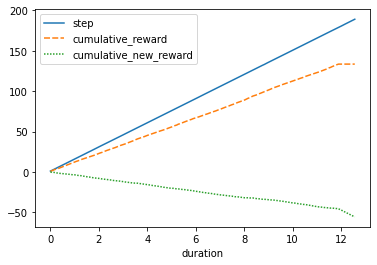

In [188]:
df = df_by_episode(full_df,1,factory,df_to_params, 'new_reward')
plot_new_reward(df,['reward','new_reward'])

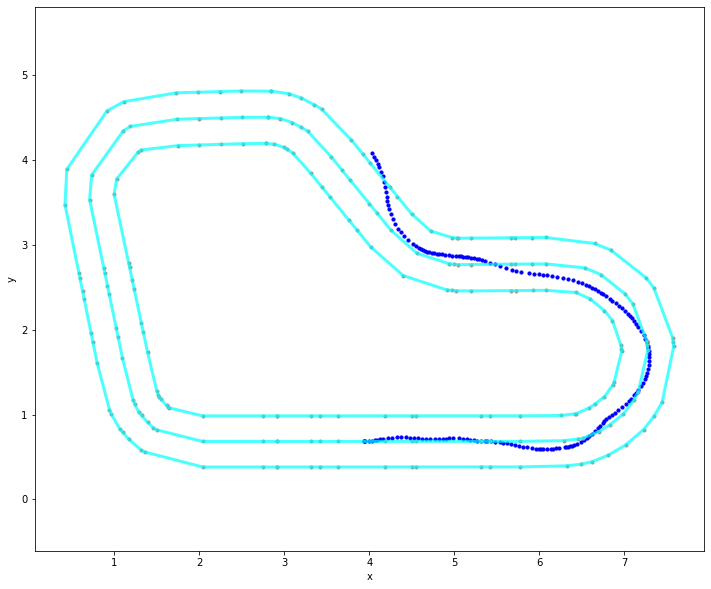

<Figure size 432x288 with 0 Axes>

In [138]:
pu.plot_selected_laps(df, new_names_df(df), track)

In [140]:
summary(df,['new_reward'])

,,step,closest_waypoint_index,progress,speed,time,reward,duration,new_reward
iteration,episode,,,,,,,,
1,1,189,4,48.9639,0.629365,00:00:12,133.469,12.568453,-55.72


# Evaluate in new_reward in sample_complete_laps

In [228]:
sample_complete_laps_path = '../logs/sample_complete_laps.csv'
scl_df = load_sample_complete_laps(sample_complete_laps_path)
calculate_iteration(scl_df)
scl_df['duration'] = scl_df[['episode','numeric_timestamp','stream']].groupby(['episode','stream']).transform(lambda x: x - x.min())

In [229]:
factory.calculate_all_rewards(scl_df,track.center_line,df_to_params,None)

In [230]:
cum_scl = calculate_cumulative_reward( scl_df,['reward']+factory.rewards())

In [227]:
import seaborn


for x in factory.rewards()[:1]:
    new_df = cum_scl.loc[:,['duration','step','stream'] + [f'cumulative_{n}' for n in ['reward',x]] ]
    new_df = new_df.set_index('duration').sort_index()
    seaborn.relplot(kind='line',col='stream',data=new_df,)

ValueError: A wide-form input must have only numeric values.